# Backtest Evaluation – Baseline Model with Holding Period (v1)

This notebook evaluates the baseline strategy that includes:
- Linear regression predictions
- Fractional position sizing
- Fixed transaction costs
- Prediction threshold
- Minimum holding period

The goal is to understand how holding periods affect:
- turnover
- equity smoothness
- drawdowns
- overall risk-adjusted performance

Input:
- data/curated/features_daily.parquet


In [ ]:
# Core libraries: pandas for tables, numpy for numerics, matplotlib for plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Baseline predictive model used in notebook
from sklearn.linear_model import LinearRegression


In [ ]:
# Load features produced by the ingestion / feature pipeline
# The file should contain columns like date, symbol, ret_1d, rvol_10, y_ret_1d
df = pd.read_parquet("../data/curated/features_daily.parquet")
# Sort by symbol/date to ensure deterministic ordering for time-based ops
df = df.sort_values(["symbol", "date"]).reset_index(drop=True)

# Quick sanity: print shape and show a sample
print(df.shape)
df.head()


(8229, 11)


,date,adj close,close,high,low,open,volume,symbol,ret_1d,rvol_10,y_ret_1d
0,2015-01-16,23.497101,26.497499,26.895000,26.299999,26.757500,314053200,AAPL,-0.007800,0.329180,0.025431
1,2015-01-20,24.102325,27.180000,27.242500,26.625000,26.959999,199599600,AAPL,0.025431,0.323760,0.007605
2,2015-01-21,24.286325,27.387501,27.764999,27.067499,27.237499,194303600,AAPL,0.007605,0.324523,0.025683
3,2015-01-22,24.918148,28.100000,28.117500,27.430000,27.565001,215185600,AAPL,0.025683,0.340529,0.005147
4,2015-01-23,25.046728,28.245001,28.437500,27.882500,28.075001,185859200,AAPL,0.005147,0.285719,0.001062


In [ ]:
# Validate required schema: ensure required columns are present
required = {"date", "symbol", "ret_1d", "rvol_10", "y_ret_1d"}
missing = required - set(df.columns)
assert not missing, f"Missing columns: {missing}"

# Ensure no NaNs in core modelling/backtest columns
assert df[["ret_1d", "rvol_10", "y_ret_1d"]].isna().sum().sum() == 0


In [ ]:
# Define features and target for the baseline model
FEATURES = ["ret_1d", "rvol_10"]
TARGET = "y_ret_1d"

# Time-based train/test split: avoid shuffling to prevent leakage
split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx]
test = df.iloc[split_idx:].copy()

# Fit a simple linear regression baseline on the training partition
model = LinearRegression()
model.fit(train[FEATURES], train[TARGET])

# Predict expected next-day returns on the held-out test set
test["prediction"] = model.predict(test[FEATURES])


In [ ]:
# Strategy hyperparameters: minimum holding period and transaction cost
HOLD_DAYS = 5
COST_BPS = 5
COST = COST_BPS / 10_000

# Thresholding: only take signals above a fraction of the prediction std
pred_std = test["prediction"].std()
THRESHOLD = 0.5 * pred_std

print("Holding days:", HOLD_DAYS)
print("Prediction threshold:", THRESHOLD)


Holding days: 5
Prediction threshold: 0.0005550539958668572


In [ ]:
# Iterate per-symbol to enforce a minimum holding period and apply thresholding
records = []

for symbol, sdf in test.groupby("symbol"):
    # Work on a local copy for the symbol to track positions/day counters
    sdf = sdf.copy().reset_index(drop=True)

    position = 0.0
    days_left = 0

    for i in range(len(sdf)):
        row = sdf.loc[i]
        trade_cost = 0.0

        # Decrement remaining holding days if currently in a position
        if days_left > 0:
            days_left -= 1

        # Open a new position only if currently flat and prediction exceeds threshold
        if position == 0.0 and row["prediction"] > THRESHOLD:
            position = min(row["prediction"] / pred_std, 1.0)
            days_left = HOLD_DAYS
            trade_cost = position * COST

        # Close position when the minimum holding period has elapsed
        elif position > 0.0 and days_left == 0:
            trade_cost = position * COST
            position = 0.0

        # Compute gross and net return for the row
        gross_ret = position * row["y_ret_1d"]
        net_ret = gross_ret - trade_cost

        records.append(
            {
                "date": row["date"],
                "symbol": symbol,
                "position": position,
                "net_ret": net_ret,
            }
        )

# Assemble recorded rows into a dataframe that represents the backtest output
bt = pd.DataFrame(records)
bt.head()


,date,symbol,position,net_ret
0,2019-05-29,SPY,1.0,0.002227
1,2019-05-30,SPY,1.0,-0.013567
2,2019-05-31,SPY,1.0,-0.002546
3,2019-06-03,SPY,1.0,0.021474
4,2019-06-04,SPY,1.0,0.008625


In [ ]:
# Aggregate per-date portfolio return by averaging across symbols
daily = (
    bt.groupby("date", as_index=False)["net_ret"]
    .mean()
    .rename(columns={"net_ret": "portfolio_ret"})
)

# Convert cumulative log returns into an equity curve starting at 1
daily["cum_log_ret"] = daily["portfolio_ret"].cumsum()
daily["equity"] = np.exp(daily["cum_log_ret"])

daily.head()


,date,portfolio_ret,cum_log_ret,equity
0,2019-05-29,0.002227,0.002227,1.002230
1,2019-05-30,-0.013567,-0.011339,0.988725
2,2019-05-31,-0.002546,-0.013886,0.986210
3,2019-06-03,0.021474,0.007589,1.007618
4,2019-06-04,0.008625,0.016214,1.016346


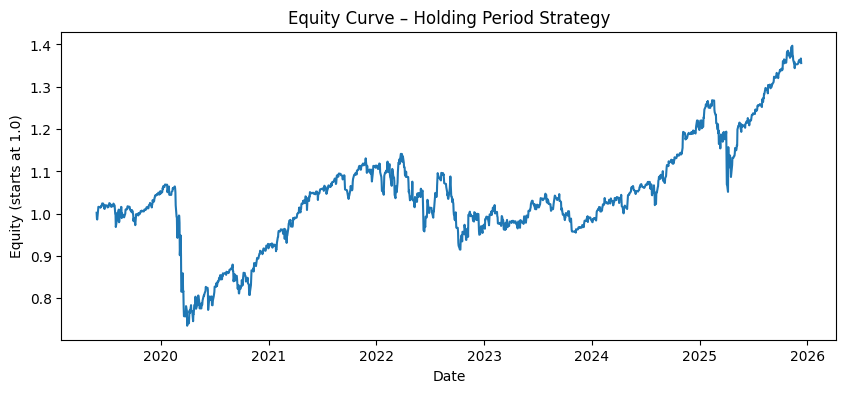

In [ ]:
# Plot equity curve for the holding-period strategy
plt.figure(figsize=(10, 4))
plt.plot(daily["date"], daily["equity"])
plt.title("Equity Curve – Holding Period Strategy")
plt.xlabel("Date")
plt.ylabel("Equity (starts at 1.0)")
plt.show()


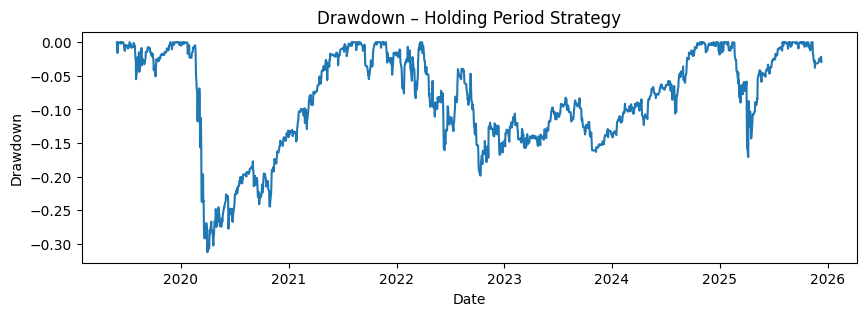

In [ ]:
# Compute drawdown relative to the running peak of equity
daily["rolling_max"] = daily["equity"].cummax()
daily["drawdown"] = daily["equity"] / daily["rolling_max"] - 1

plt.figure(figsize=(10, 3))
plt.plot(daily["date"], daily["drawdown"])
plt.title("Drawdown – Holding Period Strategy")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.show()


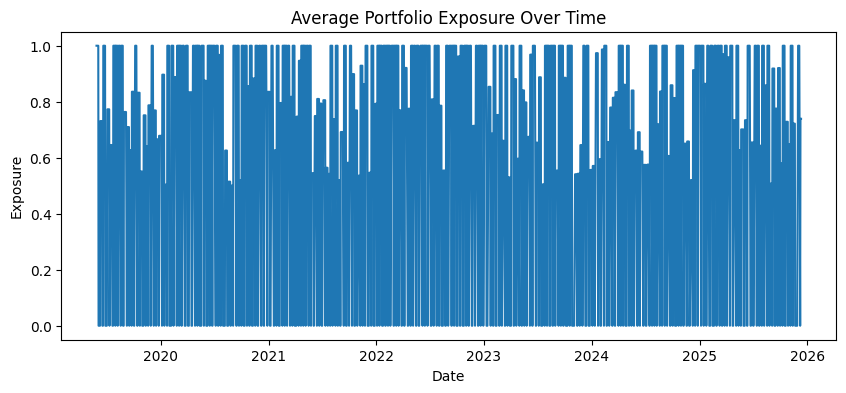

In [ ]:
# Compute average exposure across symbols to monitor crowding
exposure = (
    bt.groupby("date", as_index=False)["position"]
    .mean()
)

plt.figure(figsize=(10, 4))
plt.plot(exposure["date"], exposure["position"])
plt.title("Average Portfolio Exposure Over Time")
plt.xlabel("Date")
plt.ylabel("Exposure")
plt.show()


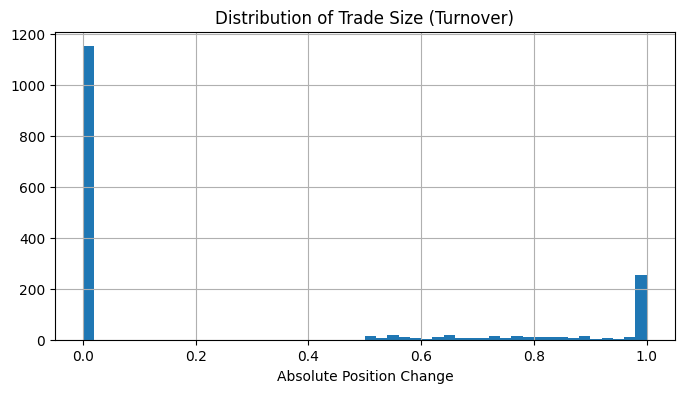

Average trade size: 0.26068853119009955


In [ ]:
# Compute turnover metrics: prev position and absolute trade size
bt["prev_position"] = bt.groupby("symbol")["position"].shift(1).fillna(0.0)
bt["trade_size"] = (bt["position"] - bt["prev_position"]).abs()

plt.figure(figsize=(8, 4))
bt["trade_size"].hist(bins=50)
plt.title("Distribution of Trade Size (Turnover)")
plt.xlabel("Absolute Position Change")
plt.show()

# Average trade size is a simple proxy for turnover
print("Average trade size:", bt["trade_size"].mean())


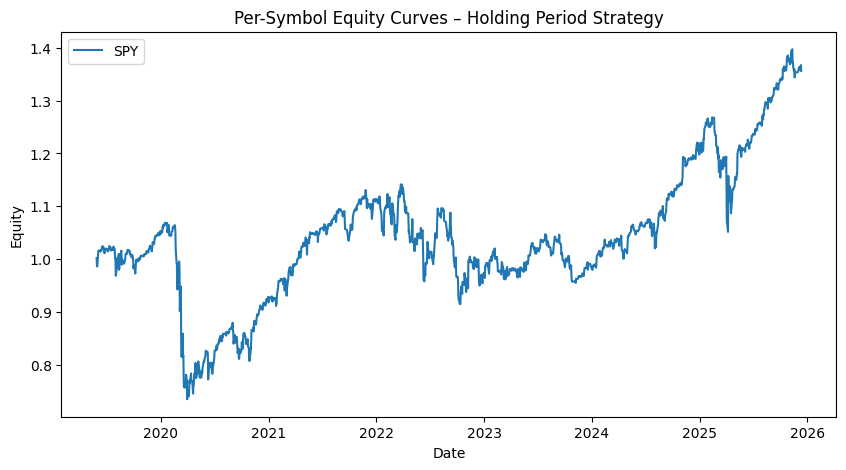

In [ ]:
# Per-symbol aggregation to inspect individual contributors to performance
sym_daily = (
    bt.groupby(["symbol", "date"], as_index=False)["net_ret"]
    .sum()
)

sym_daily["cum_log_ret"] = sym_daily.groupby("symbol")["net_ret"].cumsum()
sym_daily["equity"] = np.exp(sym_daily["cum_log_ret"])

plt.figure(figsize=(10, 5))
for sym in sym_daily["symbol"].unique():
    sub = sym_daily[sym_daily["symbol"] == sym]
    plt.plot(sub["date"], sub["equity"], label=sym)

plt.title("Per-Symbol Equity Curves – Holding Period Strategy")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.legend()
plt.show()


In [ ]:
# Compute simple performance metrics: total return, mean/std daily returns, Sharpe
total_return = daily["equity"].iloc[-1] - 1
avg_daily = daily["portfolio_ret"].mean()
vol_daily = daily["portfolio_ret"].std()
sharpe = (avg_daily / vol_daily) * np.sqrt(252) if vol_daily > 0 else np.nan
hit_rate = (daily["portfolio_ret"] > 0).mean()

print(f"Total return:     {total_return:.2%}")
print(f"Avg daily return: {avg_daily:.6e}")
print(f"Daily vol:        {vol_daily:.6e}")
print(f"Sharpe (approx):  {sharpe:.3f}")
print(f"Hit rate:         {hit_rate:.2%}")


Total return:     35.60%
Avg daily return: 1.850327e-04
Daily vol:        1.018637e-02
Sharpe (approx):  0.288
Hit rate:         41.86%
